# Demo on TensorCircuit SDK for Tencent Quantum Cloud

This notebook is not served as a full user manual for TC SDK for QCLOUD. Instead，it only highlighted a limited subset of features that TC enabled, mainly for live demo and tutorials.

## Import and Setup

In [6]:
import tensorcircuit as tc

The following two line are by default and no need to run explicitly, 
unless you activate tencent cloud service for the first time when you have to set up the token copied from the web

In [2]:
# tc.cloud.apis.set_token("123456isnotgoodpassword")
# tc.cloud.apis.set_provider("tencent")

## Devices and properties

**Provider agnostic**: The SDK architecture is designed to be provider agnostic so that we have the potential to support multiple QPU providers in the future. And from the user's pespective, no code will change to deploy the quantum program on different QPU providers. We also support some third party and local providers now internally, and the list will be expanding...


In [7]:
tc.cloud.apis.list_providers()

[tencent, local]

In [8]:
tc.cloud.apis.list_devices()

[tencent::simulator:tc,
 tencent::simulator:aer,
 tencent::simulator:tcn1,
 tencent::tianshu_s1,
 tencent::tianxuan_s1]

list only devices online that are currently available with `state` argument

In [9]:
tc.cloud.apis.list_devices("tencent", state="on")

[tencent::simulator:tc,
 tencent::simulator:aer,
 tencent::tianshu_s1,
 tencent::tianxuan_s1]

In [10]:
device_name = "tianxuan_s1"  # 9 qubits chip

# get the device object

d = tc.cloud.apis.get_device(device_name)

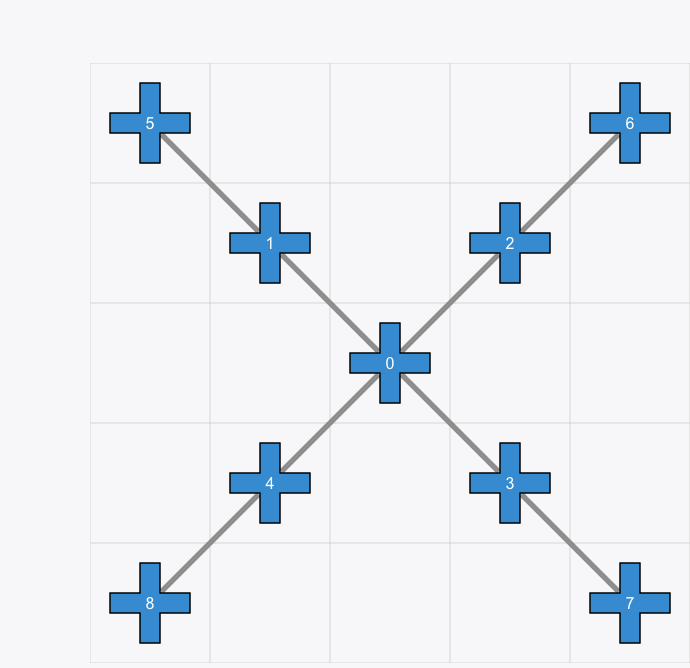

In [46]:
from IPython.display import Image

Image(filename="../statics/tianxuan_s1.png")

In [11]:
d.list_properties()

{'id': 'tianxuan_s1',
 'type': 'CHIP',
 'qubits': 9,
 'T1': 30.593555450439453,
 'T2': 12.94344425201416,
 'Err': {'SQ': 0.0008366666666666665,
  'CZ': 0.01615125,
  'Readout': {'F0': 0.0209, 'F1': 0.0849111111111111}},
 'report': {'at': 1683908208,
  'consumed': 181292436838,
  'done': 32164,
  'total': 32175,
  'waiting': 5039},
 'at': 1685496713,
 'state': 'on',
 'links': {(0, 1): {'A': 0, 'B': 1, 'CZErrRate': 0.0135, 'GateLenInNs': 75.56},
  (0, 2): {'A': 0, 'B': 2, 'CZErrRate': 0.02358, 'GateLenInNs': 78.74},
  (0, 3): {'A': 0, 'B': 3, 'CZErrRate': 0.01899, 'GateLenInNs': 79.94},
  (0, 4): {'A': 0, 'B': 4, 'CZErrRate': 0.03357, 'GateLenInNs': 79.93},
  (1, 5): {'A': 1, 'B': 5, 'CZErrRate': 0.00552, 'GateLenInNs': 74.94},
  (2, 6): {'A': 2, 'B': 6, 'CZErrRate': 0.01951, 'GateLenInNs': 79.71},
  (3, 7): {'A': 3, 'B': 7, 'CZErrRate': 0.00422, 'GateLenInNs': 65.04},
  (4, 8): {'A': 4, 'B': 8, 'CZErrRate': 0.01032, 'GateLenInNs': 76.07}},
 'bits': {0: {'Freqency': 3974.78,
   'Qubit': 

In [12]:
d.list_properties()["bits"][2]

{'Freqency': 4106.44,
 'Qubit': 2,
 'ReadoutF0Err': 0.0192,
 'ReadoutF1Err': 0.0728,
 'SingleQubitErrRate': 0.00085,
 'SingleQubitGateLenInNs': 40,
 'T1': 18.917,
 'T2': 5.222}

In [13]:
# some meta data for the device

d.native_gates(), d.name, d.provider, d.topology()

(['h', 'rz', 'x', 'y', 'z', 'cz', 'cx'],
 'tianxuan_s1',
 tencent,
 [[0, 1],
  [6, 2],
  [4, 0],
  [0, 4],
  [8, 4],
  [1, 5],
  [3, 7],
  [0, 3],
  [2, 0],
  [5, 1],
  [3, 0],
  [7, 3],
  [0, 2],
  [2, 6],
  [4, 8],
  [1, 0]])

The native gate set and the coupling map information is essential for TC to transpile the circuits so that they conform the standard of the corresponding devices.

## Tasks

Submit a simple two-qubit task.

Note that there is no need to explicitly add any measurement operations to the circuit. By default, t.results will return the number of (Z-basis) measurement outcomes for all (in this case 2) qubits in the specified circuit

In [14]:
c = tc.Circuit(2)
c.H(0)
c.cx(0, 1)

t = tc.cloud.apis.submit_task(device=d, circuit=c, shots=1024)

t.results()  # this will wait until the result is return

{'00': 494, '11': 391, '10': 80, '01': 59}

In [15]:
c.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

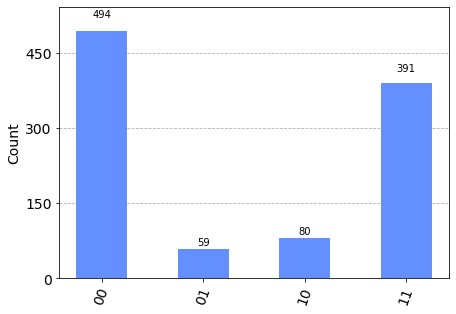

In [16]:
tc.results.counts.plot_histogram(t.results())

Check with the analytical exact result is easy, just use tensorcircuit's sota tensornetwork based simulation engine. The answer is a quantum state as $\vert 00\rangle + \vert 11\rangle$

In [17]:
p = c.probability()
print(p)
exact_result = tc.results.counts.vec2count(p, prune=True)
print(exact_result)

[0.49999997 0.         0.         0.49999997]
{'00': 0.4999999701976776, '11': 0.4999999701976776}


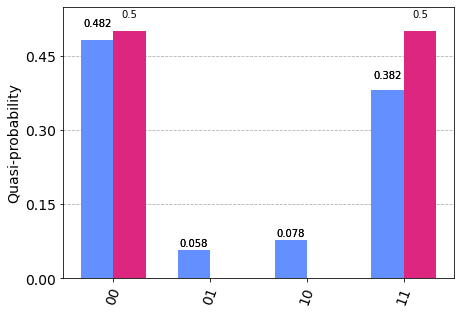

In [18]:
tc.results.counts.plot_histogram([t.results(), exact_result])
# experiment vs exact

Let us further investigate the Task object ``t`` returned by ``submit_task``, it contains enriched information on manager, compiling, etc.

In [19]:
t.details(prettify=True)

{'id': '3a8840fa-1831-48c3-85fd-67a66523ed8f',
 'queue': 'txq.low',
 'device': 'tianxuan_s1?o=3',
 'qubits': 2,
 'depth': 3,
 'state': 'completed',
 'shots': 1024,
 'prior': 1,
 'at': datetime.datetime(2023, 5, 31, 11, 45, 7, 695261),
 'ts': {'completed': datetime.datetime(2023, 5, 31, 11, 45, 7, 695261),
  'pending': datetime.datetime(2023, 5, 31, 11, 45, 6, 364959),
  'scheduled': datetime.datetime(2023, 5, 31, 11, 45, 6, 359719)},
 'md5': '9cb407b41938a256ec15dfec163dca1d',
 'runAt': 1685504730279662,
 'runDur': 1016276,
 'source': 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[2];\nh q[0];\ncx q[0],q[1];',
 'version': '1',
 'lang': 'OPENQASM',
 'result': {'00': 494, '01': 59, '10': 80, '11': 391},
 'optimization': {'progs': [{'code': 'Tencent Quantum Program\nversion 1.0\nqubit involved: q0,q1,q2,q3,q4,q5,q6,q7,q8\n# section: eqasm\n# section lines 3\neqasm program\nbs 1 H q0\nbs 1 CX (q0, q1)\nMEASZ q0,q1\n# section: end\n',
    'lang': 'QEXE'},
   {'code': 'Tencent Quantum Program

In [20]:
t.status()

'completed'

In [21]:
t.id_

'3a8840fa-1831-48c3-85fd-67a66523ed8f'

The task can be retrieved from cloud with the id without task object `t`

In [22]:
t1 = tc.cloud.apis.get_task(t.id_)

In [23]:
t1.details(prettify=True)["frontend"].draw()
# exactly the task we submitted

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

In [24]:
t1.results()

{'00': 494, '11': 391, '10': 80, '01': 59}

Task group management is also possible but not shown here. Try using ``group`` argument when ``submit_task`` and ``list_task`` when retrieving.

## Cloud simulator

We can also submit tasks to run on tc simulators on the cloud, the only thing you need to change is the device name, and now the result becomes exact.

In [25]:
c = tc.Circuit(2)
c.H(0)
c.cx(0, 1)

t = tc.cloud.apis.submit_task(device="simulator:tc", circuit=c, shots=1024)

t.results()  # this will wait until the result is return
# instead, using wait=False for t.results(wait=False), the task objects can be returned in async mode

{'11': 546, '00': 478}

**Batch submission:** Tasks can also submitted in batch, either on real devices or on simulators, a list of task object is returned by ``submit_task``, if the circuit submitted is in a list. In this way, the joint tasks are executed on the QPU at the same time so that the noise profile remains consistent.

In [26]:
c1 = tc.Circuit(2)
c1.h(0)

c2 = tc.Circuit(2)
c2.h(1)

ts = tc.cloud.apis.submit_task(device="simulator:tc", circuit=[c1, c2], shots=1024)
for t in ts:
    print(t.results())

{'10': 524, '00': 500}
{'00': 519, '01': 505}


## Compling: gate decomposition and qubit mapping

Say we want to simulate the following logic circuit, however, the gate set and the coupling for two-qubit gates are both incompatible with our real device

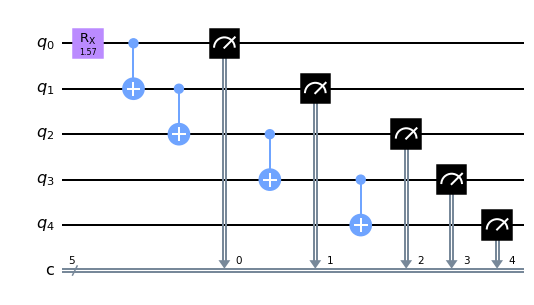

In [27]:
c = tc.Circuit(5)
c.rx(0, theta=1.5708)
for i in range(4):
    c.cx(i, i + 1)
c.measure_instruction(*range(5))
# note for tasks involving qubit mapping, we recommend you add the measure instruction explicitly
c.draw(output="mpl")

In [28]:
# the ideal answer with shot noise
c.sample(allow_state=True, batch=8192, format="count_dict_bin")

{'00000': 4014, '11111': 4178}

The target state we prepare is the so called GHZ state (here is GHZ-5), which is also famuous as Schordinger cat state, as it is a superposition of two very different (macroscopic) quantum states: $\vert 00000\rangle + \vert 11111\rangle$. GHZ state is also a great measure to determine the quality of the quantum hardware.


By default the **backend compiler** options are both enabled which we write expicitly below

In [29]:
t = tc.cloud.apis.submit_task(
    circuit=c,
    shots=8192,
    device=d,
    enable_qos_gate_decomposition=True,
    enable_qos_qubit_mapping=True,
)

In [30]:
rb = t.results()
rb

{'00000': 3794,
 '11111': 862,
 '00010': 584,
 '10000': 311,
 '00011': 258,
 '01111': 254,
 '00110': 221,
 '10111': 188,
 '00111': 176,
 '11101': 169,
 '11000': 128,
 '00100': 113,
 '11100': 104,
 '10010': 102,
 '01010': 89,
 '00001': 87,
 '10100': 84,
 '11110': 79,
 '11011': 78,
 '01011': 71,
 '01000': 66,
 '01101': 63,
 '01110': 63,
 '10110': 49,
 '01100': 43,
 '10011': 42,
 '00101': 26,
 '10101': 25,
 '10001': 18,
 '01001': 15,
 '11001': 15,
 '11010': 15}

We can inspect the circuit compiled after the backend server compiling:

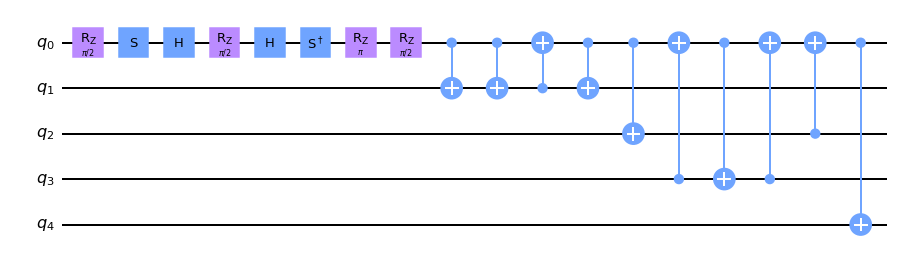

In [31]:
t.details(prettify=True)["backend"].draw(idle_wires=False, output="mpl")

In [29]:
t.get_logical_physical_mapping()  # the logical qubit - physical qubit mapping is also returned by the server

{0: 1, 1: 3, 2: 2, 3: 0, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8}

To better customize and use the advanced compiling system, we strongly recommend the users to compile the circuit before task submission as **frontend compiling**

{'logical_physical_mapping': {0: 6, 1: 2, 2: 0, 3: 4, 4: 8}, 'positional_logical_mapping': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}}


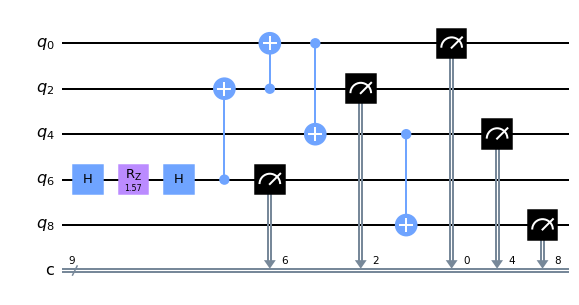

In [32]:
c1, info = tc.compiler.default_compile(
    c, compiled_options={"coupling_map": d.topology()}
)
print(info)
c1.draw(idle_wires=False, output="mpl")

We now submit the compiled circuit ``c1`` for the qcloud, with now the ``logical_physical_mapping`` in ``info``, the result is improved with tc built in compiler

In [33]:
t = tc.cloud.apis.submit_task(
    circuit=c1,
    shots=8192,
    device=d,
    enable_qos_gate_decomposition=False,
    enable_qos_qubit_mapping=False,
)
rf = t.results()
rf

{'00000': 3506,
 '11111': 1962,
 '01111': 523,
 '11011': 279,
 '10000': 262,
 '11110': 257,
 '10111': 174,
 '11000': 167,
 '00111': 148,
 '11101': 109,
 '01000': 92,
 '01011': 90,
 '00001': 87,
 '01110': 85,
 '00011': 80,
 '11100': 72,
 '11010': 45,
 '00100': 42,
 '10011': 31,
 '00110': 24,
 '01101': 24,
 '00010': 22,
 '10110': 18,
 '11001': 17,
 '01100': 16,
 '01010': 15,
 '10100': 11,
 '00101': 10,
 '10001': 10,
 '10101': 8,
 '01001': 4,
 '10010': 2}

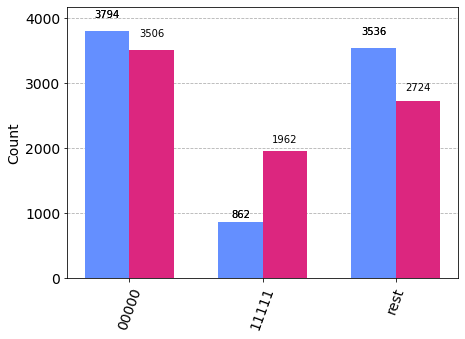

In [34]:
tc.results.counts.plot_histogram([rb, rf], number_to_keep=2)
# backend compiling vs frontend compiling

## Readout Error Mitigation

The above results can be further improved via readout error mitigation (a classical algorithmic postprocessing on the measurement results)

In [35]:
mit = tc.results.rem.ReadoutMit(d.name + "?o=0")
mit.cals_from_system(9)
mr = mit.apply_correction(t.results(), qubits=5, **info)
mr

{'00000': 3931.5654653719635,
 '11111': 3736.9302177814375,
 '11000': 156.2388037789295,
 '00111': 139.79207327296174,
 '10000': 82.70413218088015,
 '10111': 62.54914892519676,
 '11100': 40.2309011836783,
 '00011': 34.01063384376864,
 '01111': 5.923071025515406,
 '00001': 2.0555526356691276}

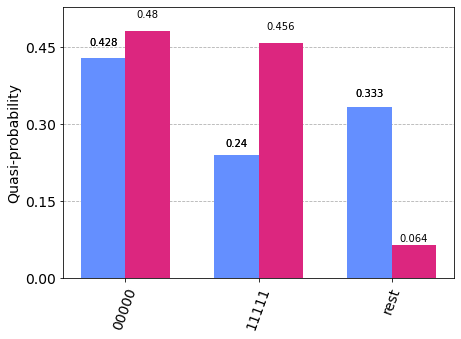

In [36]:
tc.results.counts.plot_histogram([t.results(), mr], number_to_keep=2)
# raw vs mitigated

We can also collect the readout calibriation from the API, but the results can be wrose since it is not up to date

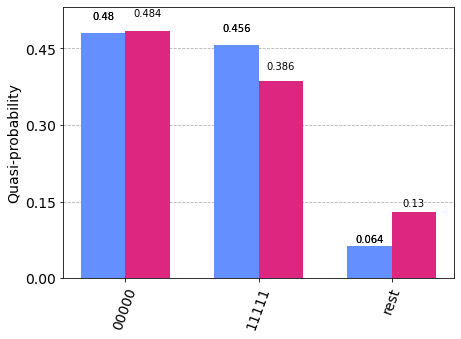

In [37]:
mit1 = tc.results.rem.ReadoutMit(d.name + "?o=0")
mit1.cals_from_api(9)
mr1 = mit1.apply_correction(t.results(), qubits=5, **info)
tc.results.counts.plot_histogram([mr, mr1], number_to_keep=2)

# mitigated via real time calibriation vs. mitigated via api calibriation data

Readout error mitigation in tc supports many other options for subset measurement, scalable mitigation for hundereds of qubits, customized calibriation in local and global mode and native error mitigated expectations, please refer to the API documentation for more interesting usages. For example, we can directly compute the expectation $<Z_0Z_1>$ (ideal value should be 1) as

In [38]:
c.expectation_ps(z=[0, 1]), mit.expectation(t.results(), [0, 1])

(array(1.+0.j, dtype=complex64), 0.9584156264735034)

## High level API

Ultimately, for near term quantum computing tasks, the users only want to evaluate some given observable expectation for a circuit without worrying too much details above: compilation, error mitigation, subset measruement, positional/logical/physical mapping etc. Therefore, for most of the applications, `batch_expectation_ps` method is all you need.

In [39]:
import logging

logger = logging.getLogger("tensorcircuit.cloud")
logger.setLevel(logging.INFO)
# ch = logging.StreamHandler()
# ch.setLevel(logging.INFO)
# logger.addHandler(ch)

# we enable log for the high level API to see what happen behind the scene

$\langle Z_0Z_1\rangle$

In [40]:
tc.cloud.wrapper.batch_expectation_ps(c, pss=[[3, 3, 0, 0, 0]], device=d)
# compute Z0Z1

INFO:tensorcircuit.cloud.wrapper:submit task on tencent::tianxuan_s1 for 1 circuits
INFO:tensorcircuit.cloud.wrapper:finished collecting count results of 1 tasks in 4.873 seconds
INFO:tensorcircuit.cloud.wrapper:submit task on tencent::tianxuan_s1 for 2 circuits
INFO:tensorcircuit.cloud.wrapper:finished collecting count results of 2 tasks in 7.6044 seconds


array([0.82589585])

$\langle Z_0Z_1\rangle+0.5\langle Z_1Z_2\rangle$

In [41]:
tc.cloud.wrapper.batch_expectation_ps(
    c, pss=[[3, 3, 0, 0, 0], [0, 3, 3, 0, 0]], device=d, ws=[1, 0.5]
)
# compute Z0Z1 + 0.5*Z1Z2

INFO:tensorcircuit.cloud.wrapper:submit task on tencent::tianxuan_s1 for 1 circuits
INFO:tensorcircuit.cloud.wrapper:finished collecting count results of 1 tasks in 4.9699 seconds


array(1.54442738)

The interface is also unifying the numerical simulation (exact) interface with QPU experiments, by spcifying the device as ``None``, we can obtain the expected result from tc simulator

In [42]:
tc.cloud.wrapper.batch_expectation_ps(
    c, pss=[[3, 3, 0, 0, 0], [0, 3, 3, 0, 0]], device=None, ws=[1, 0.5]
)

array(1.5+0.j)

The results with readout error mitigation disabled can become worse. Note how we cache the readout error calibriation within tc, so that REM is effcient to use.

In [8]:
tc.cloud.wrapper.batch_expectation_ps(
    c,
    pss=[[3, 3, 0, 0, 0], [0, 3, 3, 0, 0]],
    device=d,
    ws=[1, 0.5],
    with_rem=False,
    shots=1024,
)

INFO:tensorcircuit.cloud.wrapper:submit task on tencent::tianxuan_s1 for 1 circuits
INFO:tensorcircuit.cloud.wrapper:finished collecting count results of 1 tasks in 3.6587 seconds


array(0.8828125)

**QPU support for tf/torch ML:** Above this API, we also have corresponding keras and torch layers for hybrid deployment

In [9]:
import tensorflow as tf
from functools import partial

tc.set_backend("tensorflow")

pss = []
for i in range(5):
    ps = [0 for _ in range(5)]
    ps[i] = 3  # Z_i
    pss.append(ps)
print("Z_i:", pss)


def quantum_func(inputs, weights, device=None):
    c = tc.Circuit(5)
    for i in range(5):
        c.rx(i, theta=inputs[i])
    for i in range(5):
        c.rz(i, theta=weights[0, i])
    for i in range(5):
        c.rx(i, theta=weights[1, i])
    return tc.cloud.wrapper.batch_expectation_ps(c, pss=pss, device=device)


qlayer = tc.KerasLayer(quantum_func, [2, 5])
model = tf.keras.Sequential([qlayer, tf.keras.layers.Dense(1)])
inputs = tf.stack([0.1 * tf.ones([5]), 0.2 * tf.ones([5])])
model(inputs)

Z_i: [[3, 0, 0, 0, 0], [0, 3, 0, 0, 0], [0, 0, 3, 0, 0], [0, 0, 0, 3, 0], [0, 0, 0, 0, 3]]


<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-0.19370872],
       [-0.11048019]], dtype=float32)>

``model`` is a model with quantum layer simulated using CPU/GPU and a classical layer on CPU/GPU while ``model1`` shares exactly the same architecture but is with quantum layer on real QPU while classical layer still live on CPU/GPU, namely, TC is powerful enough to handle these quantum-classical hybrid tasks with an interface familiar to any ML engineers.

In [10]:
qlayer1 = tc.KerasHardwareLayer(partial(quantum_func, device=d), [2, 5])
model1 = tf.keras.Sequential([qlayer1, tf.keras.layers.Dense(1)])
model1(inputs)

INFO:tensorcircuit.cloud.wrapper:submit task on tencent::tianxuan_s1 for 1 circuits
INFO:tensorcircuit.cloud.wrapper:finished collecting count results of 1 tasks in 5.2411 seconds
INFO:tensorcircuit.cloud.wrapper:submit task on tencent::tianxuan_s1 for 1 circuits
INFO:tensorcircuit.cloud.wrapper:finished collecting count results of 1 tasks in 5.3121 seconds


<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-1.470755 ],
       [-1.3294612]], dtype=float32)>

In [11]:
model.summary()
print("\n")
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantum_layer (QuantumLayer  (2, 5)                   10        
 )                                                               
                                                                 
 dense (Dense)               (2, 1)                    6         
                                                                 
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hardware_layer (HardwareLay  multiple                 10        
 er)                                                             
                                                                 
 dense_1 (Dense)             multipl

we align the weights between the two models (numerical one vs hybrid one)

In [12]:
model1.set_weights(model.get_weights())
model1(inputs)

INFO:tensorcircuit.cloud.wrapper:submit task on tencent::tianxuan_s1 for 1 circuits
INFO:tensorcircuit.cloud.wrapper:finished collecting count results of 1 tasks in 5.5113 seconds
INFO:tensorcircuit.cloud.wrapper:submit task on tencent::tianxuan_s1 for 1 circuits
INFO:tensorcircuit.cloud.wrapper:finished collecting count results of 1 tasks in 5.2209 seconds


<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-0.21918973],
       [-0.1476661 ]], dtype=float32)>